In [1]:
%%html
<style>
body {
    font-family: "Times New Roman";
}
</style>  

# BUS241 Machine Learning_Group Project
### Data: December 11, 2018
### Group Members: Shaoping Huang, Ran Dou, Qimo Li, Yichen Wu, DH Suh, Salil Bharat Redkar
### Data Set: Kobe Bryant Shot Selection
(https://www.kaggle.com/c/kobe-bryant-shot-selection)

In [2]:
# basic tools
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# usual cross validation machinery
from sklearn.model_selection import train_test_split

# classification tools
# from sklearn.feature_selection import chi2
# from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge, Lasso
# from sklearn.linear_model import RidgeClassifierCV
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import roc_auc_score
# from sklearn.utils import shuffle 
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score
sns.set()

***

# 1. Data Processing

The idea behind choosing the dataset was trying to predict successful shots made by Kobe Bryant based on 25 variables which describe the shot. These include the period the shot was made in, how many minutes remained in the game, the type of shot (jump or layup) etc.  
After reading the csv file, the first part of the data cleaning involved the removal of certain columns that were thought to not help in the predictive analysis, for example the name of the team Kobe was currently in, team id as well as game ID. The next part of the process was transforming the data, which involved converting the time units into seconds, date conversions and data binning (discretizing the continuous variables) for the continuous variables that defined the longitude and latitude on the shot that was made as well as making the one-hot encoding for getting dummies for categorical variables.  

### 1.1 Data Loading

In [3]:
# import the original data set
data = pd.read_csv("data.csv")
data = data[data.shot_made_flag.isnull()==False]  # filter out all the NA value in the shot_made_flag column
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6


In [4]:
# explore the columns of the data set
columns = []
for col in data.columns:
    columns.append(col)
print(columns)

['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs', 'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id']


In [5]:
# have a look at the target dependent variable
data.shot_made_flag = data.shot_made_flag.astype(int)
data.shot_made_flag.value_counts()

0    14232
1    11465
Name: shot_made_flag, dtype: int64

### 1.2 Data Eliminating

In [6]:
data.drop('game_id', axis=1, inplace=True) # Independent
data.drop('game_event_id', axis=1, inplace=True) # Independent
data.drop('shot_id', axis=1, inplace=True) # Shot ID is unique

data.drop('lat', axis=1, inplace=True) # Correlated with loc_x
data.drop('lon', axis=1, inplace=True) # Correlated with loc_y

data.drop('team_id', axis=1, inplace=True) # Always one number
data.drop('team_name', axis=1, inplace=True) # Always LA Lakers

### 1.3 Data Transforming

In [7]:
# Remaining time
data['seconds_from_period_end'] = 60 * data['minutes_remaining'] + data['seconds_remaining']
data['last_5_sec_in_period'] = data['seconds_from_period_end'] < 5

data.drop('minutes_remaining', axis=1, inplace=True)
data.drop('seconds_remaining', axis=1, inplace=True)
data.drop('seconds_from_period_end', axis=1, inplace=True)

## Matchup - (away/home)
data['home_play'] = data['matchup'].str.contains('vs').astype('int')
data.drop('matchup', axis=1, inplace=True)

# Game date
data['game_date'] = pd.to_datetime(data['game_date'])
data['game_year'] = data['game_date'].dt.year
data['game_month'] = data['game_date'].dt.month
data.drop('game_date', axis=1, inplace=True)

# Loc_x, and loc_y binning
data['loc_x'] = pd.cut(data['loc_x'], 25)
data['loc_y'] = pd.cut(data['loc_y'], 25)

# Replace 20 least common action types with value 'Other'
rare_action_types = data['action_type'].value_counts().sort_values().index.values[:20]
data.loc[data['action_type'].isin(rare_action_types), 'action_type'] = 'Other'

### 1.4 Categorical variables to dummies

In [8]:
# get all the columns names we need to deal with
categorial_features = ['action_type', 'combined_shot_type', 'period', 'season', 'shot_type',
                   'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_year',
                   'game_month', 'opponent', 'loc_x', 'loc_y']

# change the variables above into dummy variables
data_cp = data.copy()
dummies = []
for feature in categorial_features:
    dummies.append(pd.get_dummies(data[feature], prefix=feature))
data_cp.drop(categorial_features, axis = 1, inplace = True)
data_cp = pd.concat([data_cp] + dummies, axis = 1)

In [9]:
# have a look at the eventual data set
data_cp.head()

,playoffs,shot_distance,shot_made_flag,last_5_sec_in_period,home_play,action_type_Alley Oop Dunk Shot,action_type_Alley Oop Layup shot,action_type_Driving Dunk Shot,action_type_Driving Finger Roll Layup Shot,action_type_Driving Finger Roll Shot,...,"loc_y_(457.0, 490.4]","loc_y_(490.4, 523.8]","loc_y_(523.8, 557.2]","loc_y_(557.2, 590.6]","loc_y_(590.6, 624.0]","loc_y_(624.0, 657.4]","loc_y_(657.4, 690.8]","loc_y_(690.8, 724.2]","loc_y_(724.2, 757.6]","loc_y_(757.6, 791.0]"
1,0,15,0,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,16,1,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,22,0,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,False,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,14,0,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


***

## 2. Visualizations

### 2.1 Hit Rate on Shot Types

In [10]:
# check shot types
data.combined_shot_type.value_counts()

Jump Shot    19710
Layup         4532
Dunk          1056
Tip Shot       152
Hook Shot      127
Bank Shot      120
Name: combined_shot_type, dtype: int64

Text(0.5,1,'Hit Rate for each Shot Type')

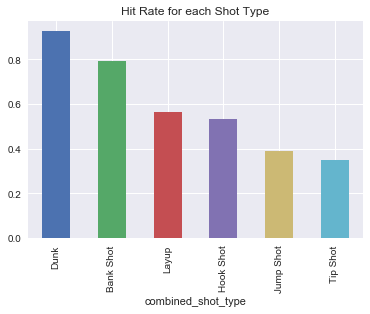

In [11]:
combined_shot_type_shot_made_rate = data.groupby('combined_shot_type')['shot_made_flag'].sum() / data.groupby('combined_shot_type')['shot_made_flag'].size()
combined_shot_type_shot_made_rate.sort_values(ascending=False, inplace = True)
combined_shot_type_shot_made_rate.plot.bar()
plt.title("Hit Rate for each Shot Type")

### 2.2 Hit Rate on Shot Zones

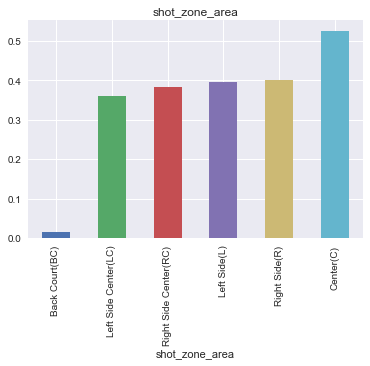

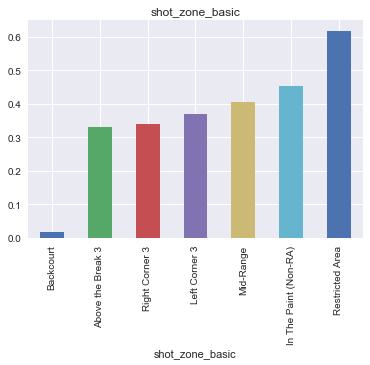

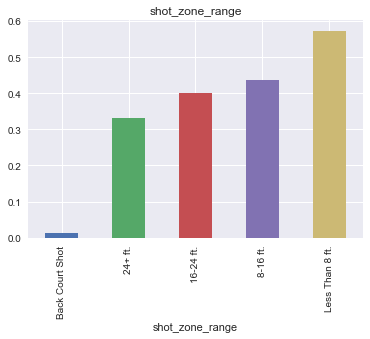

In [12]:
for feature in ['shot_zone_area', 'shot_zone_basic', 'shot_zone_range']:
    feature_rate = data.groupby(feature)['shot_made_flag'].sum() / data.groupby(feature)['shot_made_flag'].size()
    feature_rate.sort_values(inplace = True)
    feature_rate.plot.bar()
    plt.title(feature)
    plt.show()

## 3. Rearch on Ridge & Lasso
**Compare ridge and lasso on some simulated data with a large number of forecasters (right hand side) variables. Run monte-carlos to compare the two. Are there differences? Can you make any statements about which is preferred?**

Now we are going to run the Ridge and Lasso regression to penalize the magnitude of coefficients of features along with minimizing the error between predicted and actual observations.

In [13]:
# creat X and y from the original data set
X = data_cp.drop(['shot_made_flag'], axis = 1)  # make a copy of the columns to X (except shot_made_flag)
y = data_cp.shot_made_flag.copy()  # make a copy of the column shot_made_flag to y

In [14]:
# train and test data set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state =42)

### 3.1 Ridge

The Ridge regression performs the regularization that adds a factor of the sum of squares of coefficients in the optimization objective. Therefore, ridge regression optimizes the equation that Objective = RSS(Least Squares Objectives) + α * (sum of the square of coefficients). Moreover, α (alpha) is the parameter which balances the amount of emphasis given to minimizing RSS vs. minimizing the sum of the square of coefficients. In our cases, α (alpha) takes 13 values from 0.01 to 20 as the parameters on initialization toward the training dataset to figure out the value of α that returns the highest accuracy. As the value of alpha is iterated over a range of values. Also, the output shows that α = 1 returns the highest cross-validation score in comparison with all the other values and thus should be chosen. So then we applied the model with α = 1 toward the training dataset to see the level of overfitting. Then we applied the same model to the testing data set to see the accuracy of prediction.

In [15]:
alpha_range = [1e-2, 1e-1, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20] # set the range for alpha
nmc = range(50) # iteration number
rsquare_train = []
rsquare_test = []

for a in alpha_range:
    trainscore = []
    testscore = []
    for i in nmc:
        model_ridge = Ridge(alpha=a)
        model_ridge.fit(X_train, y_train)
        y_pred = model_ridge.predict(X_test)
        trainscore.append(model_ridge.score(X_train, y_train))
        testscore.append(model_ridge.score(X_test, y_test))
    mean_train = np.mean(trainscore)
    mean_test = np.mean(testscore)
    print("alpha = "+str(a)+": ")
    print("Train Set "+str(round(mean_train,4))+" | "+"Test Set "+str(round(mean_test,4)))
    rsquare_train.append(mean_train)
    rsquare_test.append(mean_test)

alpha = 0.01: 
Train Set 0.1605 | Test Set 0.1398
alpha = 0.1: 
Train Set 0.1605 | Test Set 0.1398
alpha = 1: 
Train Set 0.1604 | Test Set 0.1399
alpha = 2: 
Train Set 0.1604 | Test Set 0.14
alpha = 4: 
Train Set 0.1603 | Test Set 0.14
alpha = 6: 
Train Set 0.1603 | Test Set 0.1401
alpha = 8: 
Train Set 0.1602 | Test Set 0.1401
alpha = 10: 
Train Set 0.1601 | Test Set 0.1402
alpha = 12: 
Train Set 0.16 | Test Set 0.1402
alpha = 14: 
Train Set 0.16 | Test Set 0.1402
alpha = 16: 
Train Set 0.1599 | Test Set 0.1402
alpha = 18: 
Train Set 0.1598 | Test Set 0.1402
alpha = 20: 
Train Set 0.1597 | Test Set 0.1401


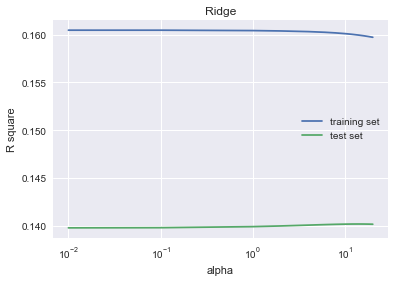

In [16]:
plt.semilogx(alpha_range, rsquare_train, label="training set")
plt.semilogx(alpha_range, rsquare_test, label="test set")
plt.ylabel("R square")
plt.xlabel("alpha")
plt.title("Ridge")
plt.legend()

### 3.2 Lasso

Regarding the Lasso regression (Least Absolute Shrinkage and Selection Operator), it performs the regualrization, which adds a factor of sum of absolute value of coefficients in the optimization objective for the equation that Objective = RSS(Least Squares Objectives) + α * (sum of absolute value of coefficients). Moreover, α (alpha) is the parameter which balances the amount of emphasis given to minimizing RSS vs. minimizing the sum of the square of coefficients. In our cases, α (alpha) takes 16 values from 0.001 to 1 as the parameters on initialization toward the training dataset to figure out the value of α that returns the highest accuracy. As the value of alpha is iterated over a range of values. Also, the output shows that α = 1 returns the highest cross-validation score in comparison with all the other values and thus should be chosen. So then we applied the model with α = 1 toward the training dataset to see the level of overfitting. Then we applied the same model to the testing data set to see the accuracy of prediction.

In [19]:
alpha_range = [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
nmc = range(50)
rsquare_train = []
rsquare_test = []

for a in alpha_range:
    trainscore = []
    testscore = []
    for i in nmc:
        model_lasso = Lasso(alpha=a)
        model_lasso.fit(X_train, y_train)
        y_pred = model_lasso.predict(X_test)
        trainscore.append(model_lasso.score(X_train, y_train))
        testscore.append(model_lasso.score(X_test, y_test))
    print("alpha = "+str(a)+": ")
    print("Train Set "+str(round(mean_train,4))+" | "+"Test Set "+str(round(mean_test,4)))
    mean_train = np.mean(trainscore)
    mean_test = np.mean(testscore)
    rsquare_train.append(mean_train)
    rsquare_test.append(mean_test)

alpha = 0.001: 
Train Set 0.0 | Test Set -0.0004
alpha = 0.005: 
Train Set 0.1477 | Test Set 0.1368
alpha = 0.01: 
Train Set 0.1265 | Test Set 0.122
alpha = 0.015: 
Train Set 0.1126 | Test Set 0.108
alpha = 0.02: 
Train Set 0.0969 | Test Set 0.0921
alpha = 0.025: 
Train Set 0.0819 | Test Set 0.0769
alpha = 0.03: 
Train Set 0.0753 | Test Set 0.0706
alpha = 0.35: 
Train Set 0.0673 | Test Set 0.0628
alpha = 0.4: 
Train Set 0.0344 | Test Set 0.0315
alpha = 0.45: 
Train Set 0.0327 | Test Set 0.03
alpha = 0.5: 
Train Set 0.0308 | Test Set 0.0282
alpha = 0.6: 
Train Set 0.0286 | Test Set 0.0263
alpha = 0.7: 
Train Set 0.0236 | Test Set 0.0217
alpha = 0.8: 
Train Set 0.0177 | Test Set 0.0162
alpha = 0.9: 
Train Set 0.0109 | Test Set 0.0098
alpha = 1: 
Train Set 0.0031 | Test Set 0.0025


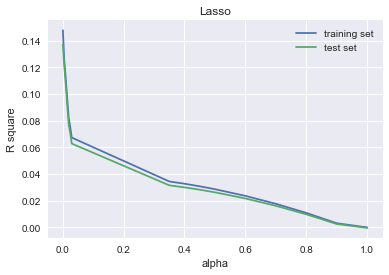

In [20]:
plt.plot(alpha_range, rsquare_train, label="training set")
plt.plot(alpha_range, rsquare_test, label="test set")
plt.ylabel("R square")
plt.xlabel("alpha")
plt.title("Lasso")
plt.legend()

The linear methods of lasso and ridge regression when applied to our dataset, predictably, result in lower accuracy scores. The large amount of right-hand side variables make it especially complicated for achieving a high score with such methods. The differences in magnitudes over all these RHS variables is also a particular problem for these methods. We advise using non-linear methods, especially SVM.

### 3.3 Ridge Classifier

We then have a try on Ridge Classifier, which seems to result in a much higher R square in both the train and the test set.

In [21]:
alpha_range = [1e-2, 1e-1, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20] # set the range for alpha
nmc = range(50)
rsquare_train = []
rsquare_test = []

for a in alpha_range:
    trainscore = []
    testscore = []
    for i in nmc:
        model_ridge = RidgeClassifier(alpha=a)
        model_ridge.fit(X_train, y_train)
        y_pred = model_ridge.predict(X_test)
        trainscore.append(model_ridge.score(X_train, y_train))
        testscore.append(model_ridge.score(X_test, y_test))
    mean_train = np.mean(trainscore)
    mean_test = np.mean(testscore)
    print("alpha = "+str(a)+": ")
    print("Train Set "+str(round(mean_train,4))+" | "+"Test Set "+str(round(mean_test,4)))
    rsquare_train.append(mean_train)
    rsquare_test.append(mean_test)

alpha = 0.01: 
Train Set 0.683 | Test Set 0.6807
alpha = 0.1: 
Train Set 0.683 | Test Set 0.6807
alpha = 1: 
Train Set 0.683 | Test Set 0.6807
alpha = 2: 
Train Set 0.6829 | Test Set 0.6805
alpha = 4: 
Train Set 0.6829 | Test Set 0.6805
alpha = 6: 
Train Set 0.6829 | Test Set 0.6811
alpha = 8: 
Train Set 0.6827 | Test Set 0.6813
alpha = 10: 
Train Set 0.6826 | Test Set 0.6817
alpha = 12: 
Train Set 0.6827 | Test Set 0.6817
alpha = 14: 
Train Set 0.6825 | Test Set 0.6821
alpha = 16: 
Train Set 0.6825 | Test Set 0.6823
alpha = 18: 
Train Set 0.6823 | Test Set 0.6821
alpha = 20: 
Train Set 0.6822 | Test Set 0.6815


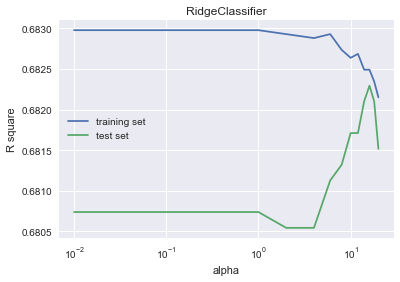

In [22]:
plt.semilogx(alpha_range, rsquare_train, label="training set")
plt.semilogx(alpha_range, rsquare_test, label="test set")
plt.ylabel("R square")
plt.xlabel("alpha")
plt.title("RidgeClassifier")
plt.legend()